In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import math
import os

In [2]:
# Import the listing of block groups
block_groups_path = os.path.join(os.path.dirname(os.path.abspath('')), 'datasets', 'block_groups_nb.json')
block_groups = gpd.read_file(block_groups_path)
# Import the list of incident locations
incident_points_path = os.path.join(os.path.dirname(os.path.abspath('')), 'datasets', 'incident_points_nb.json')
incident_points = gpd.read_file(incident_points_path)

In [3]:
# Import the list of public housing locations
public_housing_locations = pd.read_excel('/Users/Alex/Desktop/Boston University/Classes/Fall 2020/CAS CS 506 - Computational Tools for Data Science/Final Project FOR DELIVERABLE 3/Datasets/New Bedford Housing Locations.xlsx')
public_housing_locations.rename(columns={'Longtitude':'Longitude'},inplace=True)
# Add a proper geometric object to each row so we can plot these locations
public_housing_locations['shapely.geometry.Point'] = public_housing_locations.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)

In [4]:
# Calculate the approximate distance (in miles) between two points based on their longitudes and latitudes
# Needed info on the Earth's radius -- came from https://rechneronline.de/earth-radius/
# Formula used comes from https://en.wikipedia.org/wiki/Haversine_formula#Formulation
def haversine_distance(point1, point2):
    ''' Calculate the distance between two points based on latitude and longitude.
        input: two shapely.geometry.Point objects
        output: float distance (in miles)
    '''
    # Need to convert lat/long to radians for this to work
    point1_lat = point1.y * math.pi / 180
    point1_long = point1.x * math.pi / 180
    point2_lat = point2.y * math.pi / 180
    point2_long = point2.x * math.pi / 180
    # Uses the well-known Haversine formula (not perfect, but a pretty good approximation)
    inner_term = math.sin((point2_lat - point1_lat)/2)**2 + math.cos(point1_lat) * math.cos(point2_lat) * \
         math.sin((point2_long - point1_long)/2) ** 2
    distance = 2 * 3957.52 * math.asin(inner_term ** 0.5)
    return distance

In [5]:
# Find the number of incidents that occurred within x miles of a particular point
def incidents_within_radius(point, incidents, radius):
    distances_to_point = incidents.apply(lambda x: haversine_distance(x[0], point),axis=1)
    return (distances_to_point[distances_to_point <= radius]).count()

In [6]:
# For each public housing location, figure out how many incidents occurred within a certain radius of it
public_housing_locations['Incidents Within 0.1 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.1),axis=1)
public_housing_locations['Incidents Within 0.25 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.25),axis=1)
public_housing_locations['Incidents Within 0.5 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.5),axis=1)

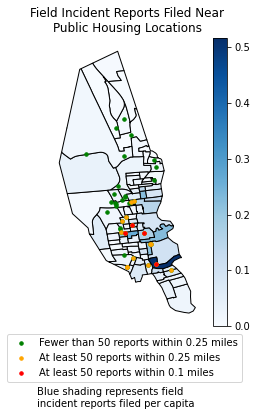

In [7]:
# On a single map, we'll do an initial plot containing just the coordinates of public housing locations
incident_radius_figure = plt.figure()
ir_axes = incident_radius_figure.add_axes([0,0,0.5,1])

# Grab the list of Point objects from the public housing locations
ph_points = gpd.GeoSeries(public_housing_locations['shapely.geometry.Point'])

# Set up a GeoPandas Coordinate Reference System for the incident locations, in order to match it with the map of New Bedford
ph_points_crs = ph_points.set_crs(crs=block_groups.crs)

# Now, make the full plot
ir_plot = block_groups.plot(column='Incidents Per Capita',cmap='Blues',edgecolor='black',axes=ir_axes,legend=True)
ph_points.plot(ax=ir_axes, marker="o",color='green',markersize=12,label='Fewer than 50 reports within 0.25 miles')

geq_50_in_quarter_mile = ph_points[public_housing_locations['Incidents Within 0.25 Miles']>=50]
geq_50_in_quarter_mile.plot(ax=ir_axes,marker="o",color='orange',markersize=12,label='At least 50 reports within 0.25 miles')

geq_50_in_tenth_of_mile = ph_points[public_housing_locations['Incidents Within 0.1 Miles']>=50]
geq_50_in_tenth_of_mile.plot(ax=ir_axes,marker="o",color='red',markersize=12,label='At least 50 reports within 0.1 miles')

ir_axes.legend(bbox_to_anchor=[1.2,-0.11,0.1,0.1])

ir_axes.set_title('Field Incident Reports Filed Near\nPublic Housing Locations')
ir_axes.axis('off')
ir_axes.text(x=-0.1,y=-0.28,s='Blue shading represents field\nincident reports filed per capita',transform=ir_axes.transAxes)
incident_radius_figure.show()